### Notes 
1. Importing Spreadsheets or CSV files (QGIS3) - https://www.qgistutorials.com/en/docs/3/importing_spreadsheets_csv.html
2. Nearest Neighbor Analysis (QGIS3) - https://www.qgistutorials.com/en/docs/3/nearest_neighbor_analysis.html
3. Getting list of coordinates (lat,long) from OSMNX Geoseries - https://copyprogramming.com/howto/plotting-a-route-with-osmnx
4. QNEAT3 Algorithms - https://root676.github.io/OdMatrixAlgs
5. Source Paper - https://www.researchgate.net/publication/319291962_The_Traditional_Four_Steps_Transportation_Modeling_Using_Simplified_Transport_Network_A_Case_Study_of_Dhaka_City_Bangladesh

In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#from warnings import simplefilter
#simplefilter(action="ignore", category=[pd.errors.PerformanceWarning, FutureWarning])

### Steps in Generating Demand Matrix

#### A. TRIP GENERATION

#### 1. Import the barangay centroids for each city (data from philatlas.com)

In [2]:
import openpyxl

file = 'dataset_centroids_with_trip_data.xlsx'

df1 = pd.read_excel(file, sheet_name = '1 Caloocan', skiprows = [0,190])
df2 = pd.read_excel(file, sheet_name = '2 Las Pinas', skiprows = [0,22])
df3 = pd.read_excel(file, sheet_name = '3 Makati', skiprows = [0,35])
df4 = pd.read_excel(file, sheet_name = '4 Malabon', skiprows = [0,23])
df5 = pd.read_excel(file, sheet_name = '5 Mandaluyong', skiprows = [0,29])
df6 = pd.read_excel(file, sheet_name = '6 Manila', skiprows = [0,899])
df7 = pd.read_excel(file, sheet_name = '7 Marikina', skiprows = [0,18])
df8 = pd.read_excel(file, sheet_name = '8 Muntinlupa', skiprows = [0,11])
df9 = pd.read_excel(file, sheet_name = '9 Navotas', skiprows = [0,20,21,22])
df10 = pd.read_excel(file, sheet_name = '10 Paranaque', skiprows = [0,18])
df11 = pd.read_excel(file, sheet_name = '11 Pasay', skiprows = [0,203])
df12 = pd.read_excel(file, sheet_name = '12 Pasig', skiprows = [0,32])
df13 = pd.read_excel(file, sheet_name = '13 Pateros', skiprows = [0,12])
df14 = pd.read_excel(file, sheet_name = '14 Quezon', skiprows = [0,144])
df15 = pd.read_excel(file, sheet_name = '15 San Juan', skiprows = [0,23])
df16 = pd.read_excel(file, sheet_name = '16 Taguig', skiprows = [0,30])
df17 = pd.read_excel(file, sheet_name = '17 Valenzuela', skiprows = [0,35])

df_list = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17]

df = pd.concat(df_list)
df.reset_index(inplace=True,drop=True)

df.head()

Barangay Name      City        Coordinates  Population  Trip Generation  \
0    Barangay 1  Caloocan  14.6589, 120.9732        2319              176   
1   Barangay 10  Caloocan  14.6544, 120.9714        1485              113   
2  Barangay 100  Caloocan  14.6538, 120.9958         983               75   
3  Barangay 101  Caloocan  14.6505, 120.9931        2517              191   
4  Barangay 102  Caloocan  14.6497, 120.9943        1033               78   

   Trip Attraction  Unnamed: 6 District  
0              169         NaN      NaN  
1              109         NaN      NaN  
2               72         NaN      NaN  
3              184         NaN      NaN  
4               75         NaN      NaN

In [3]:
# Drop the ff. columns: Population, Unnamed, and District
df.drop(columns=["Population","Unnamed: 6","District"],inplace=True)

# Finalize Barangay Name to include the City
df["Centroid"] = list(zip(df["Barangay Name"], df["City"]))

# Convert 'Centroid' to string
df["Centroid"] = df["Centroid"].astype(str)

# Drop the ff. columns: Barangay Name, City
df.drop(columns=['Barangay Name','City'],inplace=True)

# Split 'Coordinates' column into 'Latitude' and 'Longitude', then drop
df[["Latitude","Longitude"]] = df["Coordinates"].str.split(",",expand=True)
df.drop(columns=["Coordinates"],inplace=True)

# Change 'lat' and 'lon' columns to float
df["Latitude"] = round( df["Latitude"].astype(float), 6)
df["Longitude"] = round( df["Longitude"].astype(float), 6)

df.tail()

Trip Generation  Trip Attraction                         Centroid  \
1705              511              474         ('Rincon', 'Valenzuela')   
1706              250              232        ('Tagalag', 'Valenzuela')   
1707             4085             3788          ('Ugong', 'Valenzuela')   
1708             1796             1665  ('Viente Reales', 'Valenzuela')   
1709              300              278    ('Wawang Pulo', 'Valenzuela')   

      Latitude  Longitude  
1705   14.6974   120.9590  
1706   14.7270   120.9364  
1707   14.6953   121.0112  
1708   14.7135   120.9670  
1709   14.7334   120.9277

In [4]:
df_centroids = df[["Centroid","Latitude","Longitude"]]
df_centroids.tail()

Centroid  Latitude  Longitude
1705         ('Rincon', 'Valenzuela')   14.6974   120.9590
1706        ('Tagalag', 'Valenzuela')   14.7270   120.9364
1707          ('Ugong', 'Valenzuela')   14.6953   121.0112
1708  ('Viente Reales', 'Valenzuela')   14.7135   120.9670
1709    ('Wawang Pulo', 'Valenzuela')   14.7334   120.9277

In [5]:
# Export Dataframe to file to be read into QGIS
df_centroids.to_csv('data_centroids.csv', index=False)

#### 2. Import the bus nodes

In [6]:
file = 'data_nodes.csv'

df_nodes = pd.read_csv(file)
df_nodes.head()

Node   Longitude   Latitude  Node_Number
0     Heritage Hotel  120.992405  14.536709            1
1  SM MOA Globe EDSA  120.983438  14.535123            2
2     City of Dreams  120.990660  14.523840            3
3               Pitx  120.991283  14.509360            4
4   EDSA Taft Avenue  120.999887  14.537281            5

In [7]:
len(df_nodes)

149

#### 3. Import centroids and nodes to QGIS

Layer -> Add Layer -> Add Delimited Text Layer -> Geometry CRS: [Project CRS: EPSG: 4326 - WGS 84]

The nodes are colored blue, while the centroids are colored green.

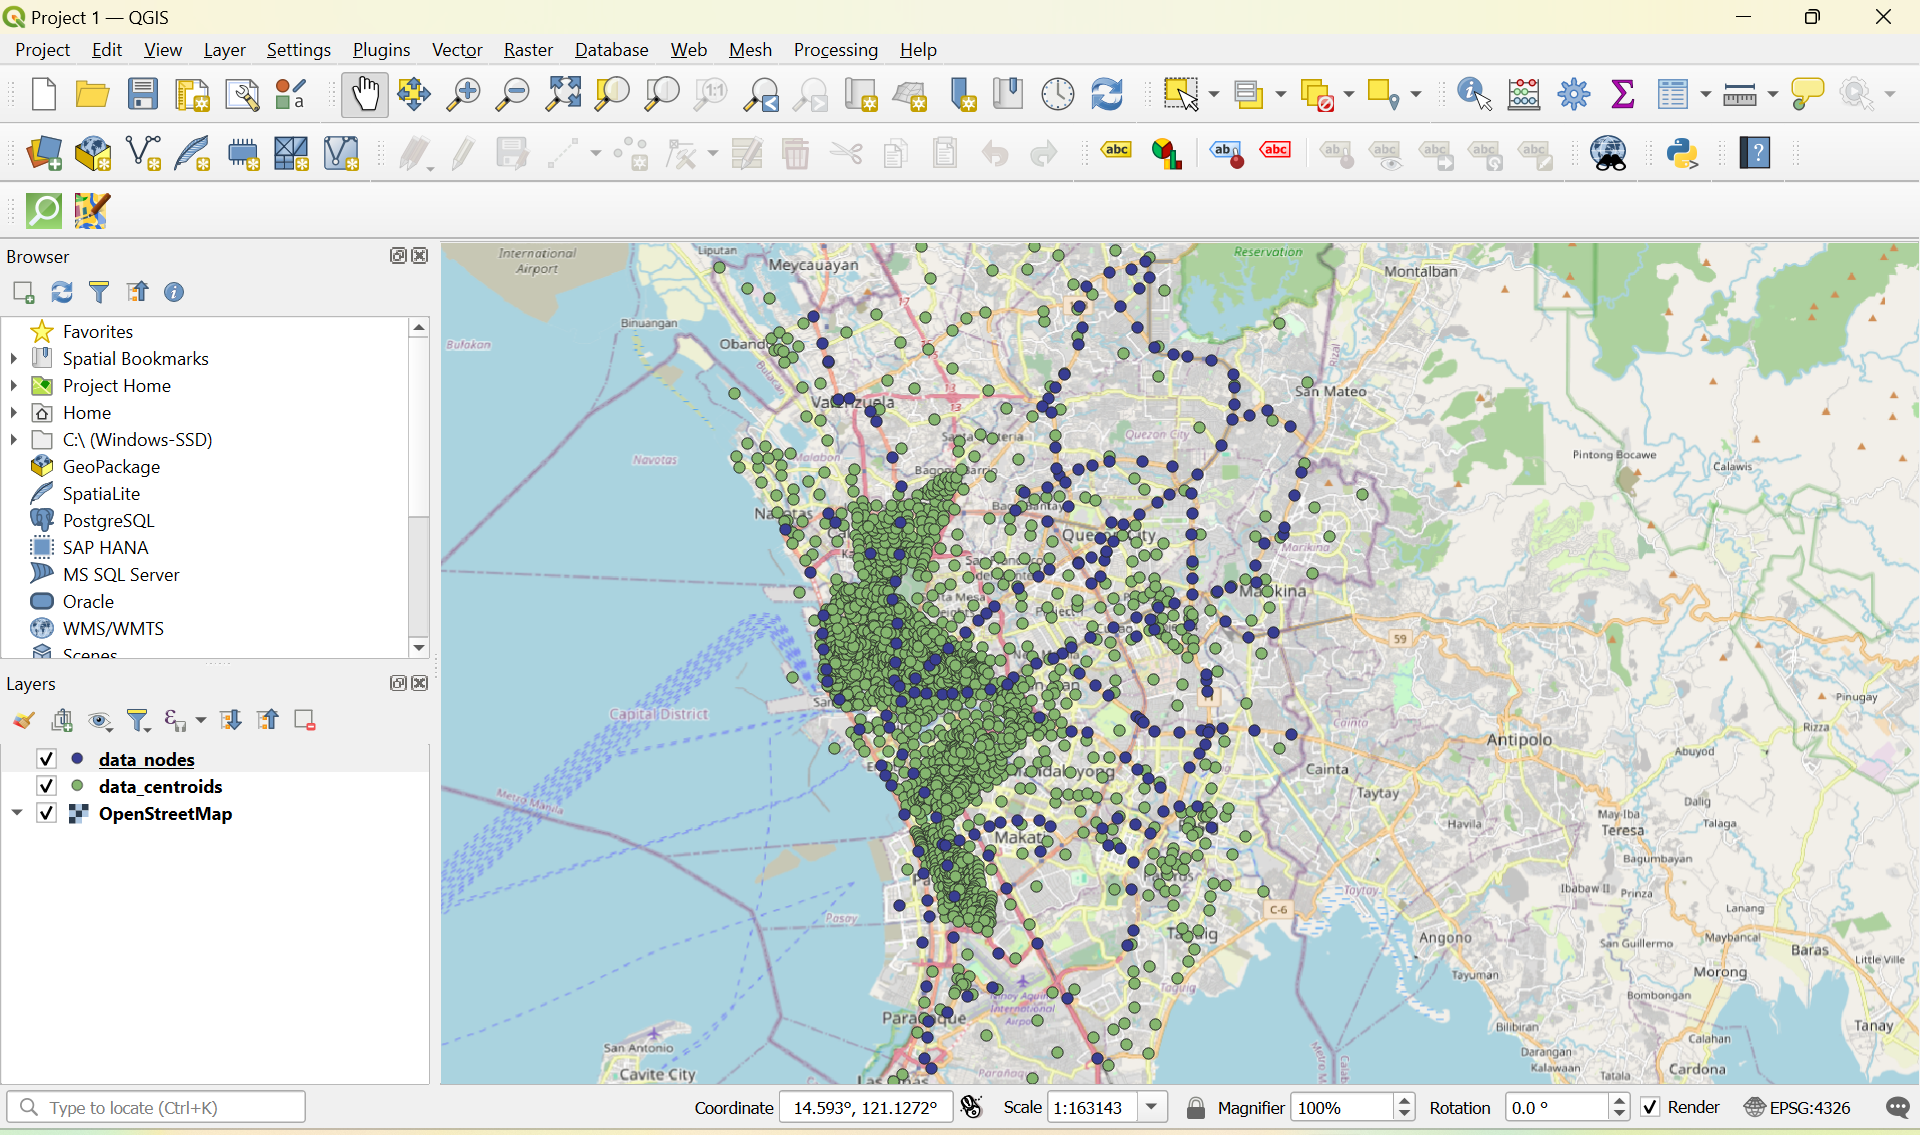

In [8]:
from IPython.display import Image

Image(filename='nodes_and_centroids.png') 

#### 4. Using QGIS, determine the nearest node per centroid

Processing -> Toolbox -> Vector Analysis -> Distance to nearest hub (line to hub) -> Hub Distance: meters

##### Export "Hub Distance" as a csv file named "centroid_to_nearest_node.csv"

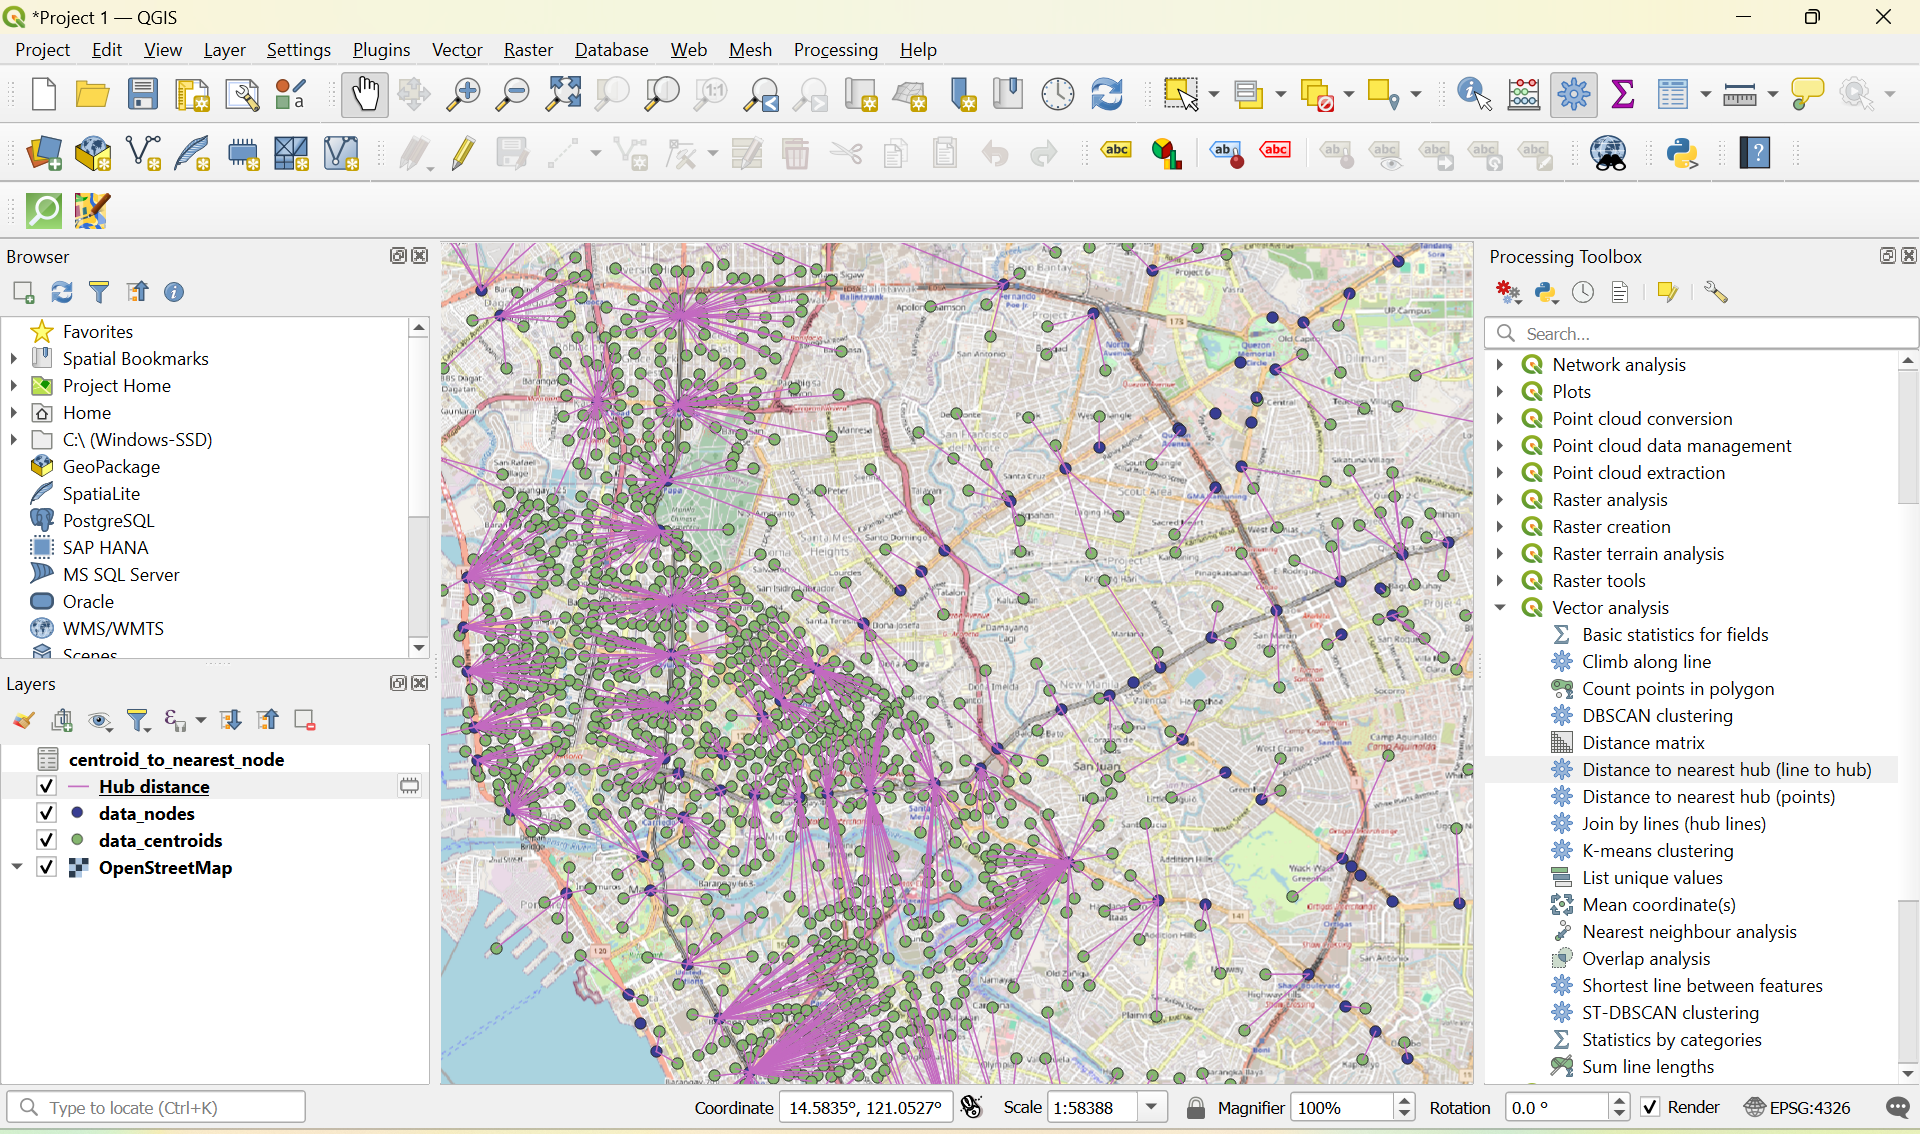

In [9]:
Image(filename='centroid_to_node.png') 

In [10]:
# Import CSV File generated from QGIS
df_centroid_to_node = pd.read_csv("centroid_to_nearest_node.csv")
df_centroid_to_node.head()

Centroid  Latitude  Longitude                  HubName  \
0    ('Barangay 1', 'Caloocan')   14.6589   120.9732         Lapu-Lapu Avenue   
1   ('Barangay 10', 'Caloocan')   14.6544   120.9714         Lapu-Lapu Avenue   
2  ('Barangay 100', 'Caloocan')   14.6538   120.9958  Balintawak Bus Terminal   
3  ('Barangay 101', 'Caloocan')   14.6505   120.9931              Sgt. Rivera   
4  ('Barangay 102', 'Caloocan')   14.6497   120.9943              Sgt. Rivera   

       HubDist  
0  1116.361944  
1   817.085510  
2   611.190499  
3   704.765722  
4   615.388438

In [11]:
# Rename columns
df_centroid_to_node.rename(columns={'HubName':'Node','HubDist':'Distance'}, inplace=True)
df_centroid_to_node.head()

Centroid  Latitude  Longitude                     Node  \
0    ('Barangay 1', 'Caloocan')   14.6589   120.9732         Lapu-Lapu Avenue   
1   ('Barangay 10', 'Caloocan')   14.6544   120.9714         Lapu-Lapu Avenue   
2  ('Barangay 100', 'Caloocan')   14.6538   120.9958  Balintawak Bus Terminal   
3  ('Barangay 101', 'Caloocan')   14.6505   120.9931              Sgt. Rivera   
4  ('Barangay 102', 'Caloocan')   14.6497   120.9943              Sgt. Rivera   

      Distance  
0  1116.361944  
1   817.085510  
2   611.190499  
3   704.765722  
4   615.388438

In [12]:
# Get the no. of unique nodes
df_centroid_to_node["Node"].nunique()

141

In [13]:
len(df_nodes)

149

In [14]:
# Re-run using unused nodes
list1 = list(df_nodes["Node"])
list2 = list(df_centroid_to_node["Node"].unique())
nodes_to_rerun = list(set(list1)-set(list2))
len(nodes_to_rerun)

8

In [15]:
# Set index
df_nodes.set_index("Node", inplace = True)
df_nodes.head()

Longitude   Latitude  Node_Number
Node                                                 
Heritage Hotel     120.992405  14.536709            1
SM MOA Globe EDSA  120.983438  14.535123            2
City of Dreams     120.990660  14.523840            3
Pitx               120.991283  14.509360            4
EDSA Taft Avenue   120.999887  14.537281            5

In [16]:
df_nodes_rerun = df_nodes.loc[nodes_to_rerun]
df_nodes_rerun.head()

Longitude   Latitude  Node_Number
Node                                                        
SM MOA Globe EDSA         120.983438  14.535123            2
DFA                       120.989600  14.530030          136
City of Dreams            120.990660  14.523840            3
Mindanao - Congressional  121.033819  14.668324          111
C-5 Ortigas               121.079560  14.589657           78

In [17]:
df_nodes_rerun.to_csv('nodes_to_rerun.csv', index=True)

In [18]:
# Import CSV File generated from QGIS
df_centroid_to_node_rerun = pd.read_csv("centroid_to_nearest_node_rerun.csv")
df_centroid_to_node_rerun.tail()

Node   Longitude   Latitude  Node_Number  \
3  Mindanao - Congressional  121.033819  14.668324          111   
4                       DFA  120.989600  14.530030          136   
5             Lanuza Avenue  121.073864  14.578080           80   
6            City of Dreams  120.990660  14.523840            3   
7         SM MOA Globe EDSA  120.983438  14.535123            2   

                        HubName      HubDist  
3  ('Bagong Pag-asa', 'Quezon')   668.054696  
4     ('Baclaran', 'Paranaque')   900.717187  
5            ('Ugong', 'Pasig')   514.707558  
6        ('Tambo', 'Paranaque')  1028.157219  
7      ('Barangay 76', 'Pasay')  1312.665852

In [19]:
# Rename columns
df_centroid_to_node_rerun.rename(columns={'HubName':'Centroid','HubDist':'Distance'}, inplace=True)
df_centroid_to_node_rerun.drop(columns=["Node_Number"], inplace=True)

df_centroid_to_node_rerun.head()

Node   Longitude   Latitude  \
0               C-5 Ortigas  121.079560  14.589657   
1            Visayas Avenue  121.042675  14.671926   
2            Heritage Hotel  120.992405  14.536709   
3  Mindanao - Congressional  121.033819  14.668324   
4                       DFA  120.989600  14.530030   

                       Centroid    Distance  
0          ('Rosario', 'Pasig')  640.277038  
1     ('Pasong Tamo', 'Quezon')  742.092332  
2      ('Barangay 75', 'Pasay')  518.604536  
3  ('Bagong Pag-asa', 'Quezon')  668.054696  
4     ('Baclaran', 'Paranaque')  900.717187

In [20]:
df_centroid_to_node_final = pd.concat([df_centroid_to_node, df_centroid_to_node_rerun])
df_centroid_to_node_final.head()

Centroid  Latitude  Longitude                     Node  \
0    ('Barangay 1', 'Caloocan')   14.6589   120.9732         Lapu-Lapu Avenue   
1   ('Barangay 10', 'Caloocan')   14.6544   120.9714         Lapu-Lapu Avenue   
2  ('Barangay 100', 'Caloocan')   14.6538   120.9958  Balintawak Bus Terminal   
3  ('Barangay 101', 'Caloocan')   14.6505   120.9931              Sgt. Rivera   
4  ('Barangay 102', 'Caloocan')   14.6497   120.9943              Sgt. Rivera   

      Distance  
0  1116.361944  
1   817.085510  
2   611.190499  
3   704.765722  
4   615.388438

In [21]:
df_centroid_to_node_final.to_csv('centroid_to_nearest_node_final.csv', index=False)

In [22]:
df_centroid_to_node_final["Centroid"].nunique()

1710

In [23]:
df_centroid_to_node_final["Node"].nunique()

149

In [24]:
len(df_centroid_to_node_final)

1718

#### 5. Centroids to Corresponding Node

In [25]:
df_cn = df_centroid_to_node_final[["Centroid","Node"]]
df_node_to_centroid = df_cn.groupby(['Node'])['Centroid'].apply(list).reset_index()
df_node_to_centroid.set_index("Node", inplace=True)
df_node_to_centroid.head()

Centroid
Node                                                                    
5Th Avenue - Caloocan  [('Barangay 104', 'Caloocan'), ('Barangay 106'...
5Th Avenue Cor. R10    [('Barangay 124', 'Manila'), ('Barangay 125', ...
A.Mabini Avenue        [('Barangay 13', 'Caloocan'), ('Barangay 15', ...
Abad Santos            [('Barangay 33', 'Caloocan'), ('Barangay 36', ...
Alabang                [('Alabang', 'Muntinlupa'), ('Bayanan', 'Munti...

#### 6. Centroids and Nodes: Trip_Generation and Trip_Attraction

In [26]:
df_gen_att = df[["Centroid","Trip Generation","Trip Attraction"]]
df_gen_att.set_index("Centroid", inplace=True)
df_gen_att.head()

Trip Generation  Trip Attraction
Centroid                                                      
('Barangay 1', 'Caloocan')                176              169
('Barangay 10', 'Caloocan')               113              109
('Barangay 100', 'Caloocan')               75               72
('Barangay 101', 'Caloocan')              191              184
('Barangay 102', 'Caloocan')               78               75

In [27]:
centroids_list = df_node_to_centroid["Centroid"].to_list()
# Initialization
list_gen_cen = []
list_att_cen = []
for centroids in centroids_list:
    list_gen = []
    list_att = []  
    for centroid in centroids:
        gen = df_gen_att["Trip Generation"][centroid]
        list_gen.append(gen)
        att = df_gen_att["Trip Attraction"][centroid]
        list_att.append(att)
    list_gen_cen.append(list_gen)
    list_att_cen.append(list_att)
df_node_to_centroid["List_Trip_Generation"] = list_gen_cen
df_node_to_centroid["List_Trip_Attraction"] = list_att_cen
df_node_to_centroid.head()

Centroid  \
Node                                                                       
5Th Avenue - Caloocan  [('Barangay 104', 'Caloocan'), ('Barangay 106'...   
5Th Avenue Cor. R10    [('Barangay 124', 'Manila'), ('Barangay 125', ...   
A.Mabini Avenue        [('Barangay 13', 'Caloocan'), ('Barangay 15', ...   
Abad Santos            [('Barangay 33', 'Caloocan'), ('Barangay 36', ...   
Alabang                [('Alabang', 'Muntinlupa'), ('Bayanan', 'Munti...   

                                                    List_Trip_Generation  \
Node                                                                       
5Th Avenue - Caloocan  [68, 27, 54, 51, 56, 33, 112, 86, 17, 75, 80, ...   
5Th Avenue Cor. R10    [15, 429, 111, 54, 2254, 280, 163, 885, 736, 141]   
A.Mabini Avenue        [81, 108, 269, 259, 829, 277, 598, 211, 429, 2...   
Abad Santos            [414, 312, 68, 184, 114, 35, 50, 133, 84, 98, ...   
Alabang                                               [7794, 4293, 2754]   

                                                    List_Trip_Attraction  
Node                                                                      
5Th Avenue - Caloocan  [66, 26, 52, 49, 54, 32, 108, 83, 17, 72, 77, ...  
5Th Avenue Cor. R10    [15, 420, 108, 53, 2208, 274, 159, 984, 818, 157]  
A.Mabini Avenue        [78, 104, 259, 250, 799, 267, 577, 204, 413, 2...  
Abad Santos            [399, 301, 65, 180, 112, 35, 49, 131, 82, 96, ...  
Alabang                                               [8298, 4571, 2932]

In [28]:
trip_gen_list = df_node_to_centroid["List_Trip_Generation"].to_list()
trip_att_list = df_node_to_centroid["List_Trip_Attraction"].to_list()
# Initialization
list_gen_sum = []
list_att_sum = []
for trip_gen in trip_gen_list:
    gen_sum = sum(trip_gen)
    list_gen_sum.append(gen_sum)
for trip_att in trip_att_list:
    att_sum = sum(trip_att)
    list_att_sum.append(att_sum)

df_node_to_centroid["Trip_Generation"] = list_gen_sum
df_node_to_centroid["Trip_Attraction"] = list_att_sum
df_node_to_centroid.drop(columns=["List_Trip_Generation","List_Trip_Attraction"], inplace=True)
df_node_to_centroid.head()

Centroid  \
Node                                                                       
5Th Avenue - Caloocan  [('Barangay 104', 'Caloocan'), ('Barangay 106'...   
5Th Avenue Cor. R10    [('Barangay 124', 'Manila'), ('Barangay 125', ...   
A.Mabini Avenue        [('Barangay 13', 'Caloocan'), ('Barangay 15', ...   
Abad Santos            [('Barangay 33', 'Caloocan'), ('Barangay 36', ...   
Alabang                [('Alabang', 'Muntinlupa'), ('Bayanan', 'Munti...   

                       Trip_Generation  Trip_Attraction  
Node                                                     
5Th Avenue - Caloocan             3295             3182  
5Th Avenue Cor. R10               5068             5196  
A.Mabini Avenue                  12347            11907  
Abad Santos                      10702            10473  
Alabang                          14841            15801

#### B. TRIP DISTRIBUTION

#### 7. Adjust Trip Attraction

In [29]:
list_nodes = list(df_node_to_centroid.index)
no_of_nodes = len(list_nodes)
list_node_numbers = range(0,no_of_nodes)
list_elements = [0] * no_of_nodes

df_trip_distribution = pd.DataFrame(df_node_to_centroid["Trip_Generation"], index=df_node_to_centroid.index)
for node in list_nodes:
    df_trip_distribution[node] = [0] * no_of_nodes

df_trip_distribution.loc[len(df_trip_distribution.index)] = [0] + df_node_to_centroid["Trip_Attraction"].to_list()

# CHANGE the dictionary key below (len(df_trip_distribution.index))
index_last = len(df_trip_distribution.index) - 1
df_trip_distribution.rename(index={index_last:'Trip_Attraction'},inplace=True)
df_trip_distribution

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33388\2717548286.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trip_distribution[node] = [0] * no_of_nodes
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33388\2717548286.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trip_distribution[node] = [0] * no_of_nodes
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33388\2717548286.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Trip_Generation  5Th Avenue - Caloocan  \
Node                                                            
5Th Avenue - Caloocan             3295                      0   
5Th Avenue Cor. R10               5068                      0   
A.Mabini Avenue                  12347                      0   
Abad Santos                      10702                      0   
Alabang                          14841                      0   
...                                ...                    ...   
Victoneta Avenue                  8593                      0   
Visayas Avenue                   21345                      0   
Waltermart Sucat                 27237                      0   
Zabarte Road                     19765                      0   
Trip_Attraction                      0                   3182   

                       5Th Avenue Cor. R10  A.Mabini Avenue  Abad Santos  \
Node                                                                       
5Th Avenue - Caloocan                    0                0            0   
5Th Avenue Cor. R10                      0                0            0   
A.Mabini Avenue                          0                0            0   
Abad Santos                              0                0            0   
Alabang                                  0                0            0   
...                                    ...              ...          ...   
Victoneta Avenue                         0                0            0   
Visayas Avenue                           0                0            0   
Waltermart Sucat                         0                0            0   
Zabarte Road                             0                0            0   
Trip_Attraction                       5196            11907        10473   

                       Alabang  Amparo  Anastacio Road  Antonio Arnaiz Avenue  \
Node                                                                            
5Th Avenue - Caloocan        0       0               0                      0   
5Th Avenue Cor. R10          0       0               0                      0   
A.Mabini Avenue              0       0               0                      0   
Abad Santos                  0       0               0                      0   
Alabang                      0       0               0                      0   
...                        ...     ...             ...                    ...   
Victoneta Avenue             0       0               0                      0   
Visayas Avenue               0       0               0                      0   
Waltermart Sucat             0       0               0                      0   
Zabarte Road                 0       0               0                      0   
Trip_Attraction          15801    3422           29501                   3974   

                       Araneta Avenue - Quezon  ...  United Nations Avenue  \
Node                                            ...                          
5Th Avenue - Caloocan                        0  ...                      0   
5Th Avenue Cor. R10                          0  ...                      0   
A.Mabini Avenue                              0  ...                      0   
Abad Santos                                  0  ...                      0   
Alabang                                      0  ...                      0   
...                                        ...  ...                    ...   
Victoneta Avenue                             0  ...                      0   
Visayas Avenue                               0  ...                      0   
Waltermart Sucat                             0  ...                      0   
Zabarte Road                                 0  ...                      0   
Trip_Attraction                           7059  ...                   4726   

                       Upper McKinley Road  V.Mapa    VGC  Valencia  \
Node                                            

In [30]:
# Must be equal
print(sum(list(df_trip_distribution["Trip_Generation"])))
print(sum(list(df_node_to_centroid["Trip_Generation"])))

1696846
1696846


In [31]:
# Solve for adjustment_factor
total_trip_generation = sum(list(df_trip_distribution["Trip_Generation"]))
total_trip_attraction = sum(list(df_node_to_centroid["Trip_Attraction"]))
adjustment_factor = round(total_trip_generation/total_trip_attraction,4)
adjustment_factor

0.9937

In [32]:
# Adjusted total trip attraction
original_trip_attraction_list = df_trip_distribution.loc["Trip_Attraction"].to_list()
adjusted_trip_attraction_list = []

for e in original_trip_attraction_list:
    adjusted_trip_attraction_list.append(int(e*adjustment_factor))

#print(original_trip_attraction_list)
#print(adjusted_trip_attraction_list)
#print(total_trip_generation)
#print(sum(adjusted_trip_attraction_list))

In [33]:
df_trip_distribution.loc[len(df_trip_distribution.index)] = adjusted_trip_attraction_list

index_last = len(df_trip_distribution.index) - 1
df_trip_distribution.rename(index={index_last:'Adjusted_Trip_Attraction'},inplace=True)

# Drop "Trip_Attraction" row
df_trip_distribution.drop(index=["Trip_Attraction"], inplace=True)

df_trip_distribution

Trip_Generation  5Th Avenue - Caloocan  \
Node                                                               
5Th Avenue - Caloocan                3295                      0   
5Th Avenue Cor. R10                  5068                      0   
A.Mabini Avenue                     12347                      0   
Abad Santos                         10702                      0   
Alabang                             14841                      0   
...                                   ...                    ...   
Victoneta Avenue                     8593                      0   
Visayas Avenue                      21345                      0   
Waltermart Sucat                    27237                      0   
Zabarte Road                        19765                      0   
Adjusted_Trip_Attraction                0                   3161   

                          5Th Avenue Cor. R10  A.Mabini Avenue  Abad Santos  \
Node                                                                          
5Th Avenue - Caloocan                       0                0            0   
5Th Avenue Cor. R10                         0                0            0   
A.Mabini Avenue                             0                0            0   
Abad Santos                                 0                0            0   
Alabang                                     0                0            0   
...                                       ...              ...          ...   
Victoneta Avenue                            0                0            0   
Visayas Avenue                              0                0            0   
Waltermart Sucat                            0                0            0   
Zabarte Road                                0                0            0   
Adjusted_Trip_Attraction                 5163            11831        10407   

                          Alabang  Amparo  Anastacio Road  \
Node                                                        
5Th Avenue - Caloocan           0       0               0   
5Th Avenue Cor. R10             0       0               0   
A.Mabini Avenue                 0       0               0   
Abad Santos                     0       0               0   
Alabang                         0       0               0   
...                           ...     ...             ...   
Victoneta Avenue                0       0               0   
Visayas Avenue                  0       0               0   
Waltermart Sucat                0       0               0   
Zabarte Road                    0       0               0   
Adjusted_Trip_Attraction    15701    3400           29315   

                          Antonio Arnaiz Avenue  Araneta Avenue - Quezon  ...  \
Node                                                                      ...   
5Th Avenue - Caloocan                         0                        0  ...   
5Th Avenue Cor. R10                           0                        0  ...   
A.Mabini Avenue                               0                        0  ...   
Abad Santos                                   0                        0  ...   
Alabang                                       0                        0  ...   
...                                         ...                      ...  ...   
Victoneta Avenue                              0                        0  ...   
Visayas Avenue                                0                        0  ...   
Waltermart Sucat                              0                        0  ...   
Zabarte Road                                  0                        0  ...   
Adjusted_Trip_Attraction                   3948                     7014  ...   

                          United Nations Avenue  Upper McKinley Road  V.Mapa  \
Node                                                                           
5Th Avenue - Caloocan                         0                    0       0   
5Th Avenue Cor. R10      

#### 8. Nodes: Cost Matrix (in terms of time) using QGIS
Network Type: https://www.qgistutorials.com/en/docs/3/downloading_osm_data.html

1. Vector -> QuickOSM -> QuickOSM dialog box -> Bus Network: 'type'='route' AND 'public_transport:version'='2', In: Metro Manila

2. Processing -> Toolbox -> QNEAT3 -> Distance Matrices -> OD-Matrix From Points as Table (n:n)

 Parameters:
 Network Layer: network, Point Layer: nodes, Unique Point ID Field: Node Number, Optimization: Fastest Path

input: data_nodes.csv, output: bus_cost_matrix.csv (total_cost column, unit in meters)

In [34]:
df_cost_matrix = pd.read_csv("bus_network_cost_matrix.csv")
df_cost_matrix.head()

origin_id  destination_id  entry_cost  network_cost  exit_cost   total_cost
0          1               1    0.000000      0.000000   0.000000     0.000000
1          1               2         NaN           NaN        NaN          NaN
2          1               3    0.585584   1256.798301   4.913261  1262.297146
3          1               4    0.585584   2782.562829   0.172792  2783.321204
4          1               5    0.585584    609.187767  12.707580   622.480930

In [35]:
# Drop Columns
df_cost_matrix = df_cost_matrix.drop(columns=["entry_cost","network_cost","exit_cost"])

# Assign Values
rows = len(df_nodes) 
cols = rows 
cost_mat = [[0 for _ in range(cols)] for _ in range(rows)]
for a in range(0, len(df_cost_matrix)):
    i = df_cost_matrix["origin_id"][a] - 1
    j = df_cost_matrix["destination_id"][a] - 1
    cost_mat[i][j] = df_cost_matrix["total_cost"][a]
df_cost_mat = pd.DataFrame(cost_mat)

# Get the maximum value and fill-in the missing values
max_values = df_cost_mat.max()
max_value = max_values.max()
df_cost_mat = df_cost_mat.fillna(max_value)
df_cost_mat.head()

0             1             2             3             4    \
0      0.000000  36817.779509   1262.297146   2783.321204    622.480930   
1  36817.779509      0.000000  36817.779509  36817.779509  36817.779509   
2   1262.297146  36817.779509      0.000000   1603.703227   1741.459973   
3   2783.321204  36817.779509   1603.703227      0.000000   3262.484031   
4    622.480930  36817.779509   1741.459973   3262.484031      0.000000   

            5             6             7             8             9    ...  \
0   6708.284963  12745.754595  15968.017945  36817.779509   5324.778417  ...   
1  36817.779509  36817.779509  36817.779509  36817.779509  36817.779509  ...   
2   5867.289081  12657.505652  15477.879011  36817.779509   4549.428324  ...   
3   5077.436802  14165.396530  15278.919419  36817.779509   5097.983472  ...   
4   6729.173844  12148.688824  15370.952174  36817.779509   5260.633391  ...   

            139           140           141           142           143  \
0  10065.965809  20073.866842   3839.789219  22669.559608  22164.584578   
1  36817.779509  36817.779509  36817.779509  36817.779509  36817.779509   
2  11304.533826  21312.434859   4845.575414  23908.127625  23403.152595   
3  12848.115847  22856.016879   6366.599473  25451.709645  24946.734616   
4   9857.595688  19966.706281   3242.723448  22562.399046  22057.424017   

            144           145           146           147           148  
0  36817.779509   8721.864923  11834.541546   6831.226538   9256.571383  
1  36817.779509  36817.779509  36817.779509  36817.779509  36817.779509  
2  36817.779509   9727.651118  13073.109563   6054.284657   8415.575501  
3  36817.779509  11248.675177  14616.691584   6602.839805   7692.691080  
4  36817.779509   8124.799153  11734.286120   6767.081512   9277.460265  

[5 rows x 149 columns]

In [36]:
# Convert from total_cost (meter) to minute
def cost_to_min(cost):
    fixed_rate = 25    # kph
    cost = cost/1000   # convert to km
    min = (cost/fixed_rate)*60
    return min

df_cost_mat = pd.DataFrame(df_cost_mat.apply(cost_to_min))
df_cost_mat.head()

0          1          2          3          4          5    \
0   0.000000  88.362671   3.029513   6.679971   1.493954  16.099884   
1  88.362671   0.000000  88.362671  88.362671  88.362671  88.362671   
2   3.029513  88.362671   0.000000   3.848888   4.179504  14.081494   
3   6.679971  88.362671   3.848888   0.000000   7.829962  12.185848   
4   1.493954  88.362671   4.179504   7.829962   0.000000  16.150017   

         6          7          8          9    ...        139        140  \
0  30.589811  38.323243  88.362671  12.779468  ...  24.158318  48.177280   
1  88.362671  88.362671  88.362671  88.362671  ...  88.362671  88.362671   
2  30.378014  37.146910  88.362671  10.918628  ...  27.130881  51.149844   
3  33.996952  36.669407  88.362671  12.235160  ...  30.835478  54.854441   
4  29.156853  36.890285  88.362671  12.625520  ...  23.658230  47.920095   

         141        142        143        144        145        146  \
0   9.215494  54.406943  53.195003  88.362671  20.932476  28.402900   
1  88.362671  88.362671  88.362671  88.362671  88.362671  88.362671   
2  11.629381  57.379506  56.167566  88.362671  23.346363  31.375463   
3  15.279839  61.084103  59.872163  88.362671  26.996820  35.080060   
4   7.782536  54.149758  52.937818  88.362671  19.499518  28.162287   

         147        148  
0  16.394944  22.215771  
1  88.362671  88.362671  
2  14.530283  20.197381  
3  15.846816  18.462459  
4  16.240996  22.265905  

[5 rows x 149 columns]

#### 9. Impedance Factor Values

In [37]:
beta = 0.1     # dispersion parameter

def imp_fac(cost):
    impedance_factor = np.exp(-beta*cost)
    return impedance_factor

df_impedance_factors = pd.DataFrame(df_cost_mat.apply(imp_fac))
df_impedance_factors.head()

0         1         2         3         4         5         6    \
0  1.000000  0.000145  0.738635  0.512735  0.861228  0.199890  0.046935   
1  0.000145  1.000000  0.000145  0.000145  0.000145  0.000145  0.000145   
2  0.738635  0.000145  1.000000  0.680526  0.658395  0.244596  0.047940   
3  0.512735  0.000145  0.680526  1.000000  0.457035  0.295648  0.033383   
4  0.861228  0.000145  0.658395  0.457035  1.000000  0.198890  0.054167   

        7         8         9    ...       139       140       141       142  \
0  0.021659  0.000145  0.278609  ...  0.089293  0.008085  0.397902  0.004336   
1  0.000145  0.000145  0.000145  ...  0.000145  0.000145  0.000145  0.000145   
2  0.024363  0.000145  0.335591  ...  0.066332  0.006006  0.312566  0.003221   
3  0.025555  0.000145  0.294194  ...  0.045796  0.004147  0.216973  0.002224   
4  0.024996  0.000145  0.282931  ...  0.093872  0.008296  0.459207  0.004449   

        143       144       145       146       147       148  
0  0.004895  0.000145  0.123286  0.058409  0.194078  0.108438  
1  0.000145  0.000145  0.000145  0.000145  0.000145  0.000145  
2  0.003636  0.000145  0.096846  0.043389  0.233861  0.132690  
3  0.002511  0.000145  0.067227  0.029957  0.205013  0.157829  
4  0.005023  0.000145  0.142281  0.059831  0.197089  0.107896  

[5 rows x 149 columns]

In [38]:
sum_impedance_factor = sum(df_impedance_factors)
total_trip = total_trip_generation
distribution_factor = total_trip/sum_impedance_factor
#print(sum_impedance_factor)
#print(total_trip)
#print(distribution_factor)

In [39]:
no_of_nodes = len(df_nodes) 

df2_trip_distribution = df_trip_distribution
df2_trip_distribution.columns = ["Trip_Generation"] + list(range(no_of_nodes))
df2_trip_distribution.index = list(range(no_of_nodes)) + ["Adjusted_Trip_Attraction"]

df2_trip_distribution

Trip_Generation     0     1      2      3      4  \
0                                    3295     0     0      0      0      0   
1                                    5068     0     0      0      0      0   
2                                   12347     0     0      0      0      0   
3                                   10702     0     0      0      0      0   
4                                   14841     0     0      0      0      0   
...                                   ...   ...   ...    ...    ...    ...   
145                                  8593     0     0      0      0      0   
146                                 21345     0     0      0      0      0   
147                                 27237     0     0      0      0      0   
148                                 19765     0     0      0      0      0   
Adjusted_Trip_Attraction                0  3161  5163  11831  10407  15701   

                             5      6     7     8  ...   139    140   141  \
0                            0      0     0     0  ...     0      0     0   
1                            0      0     0     0  ...     0      0     0   
2                            0      0     0     0  ...     0      0     0   
3                            0      0     0     0  ...     0      0     0   
4                            0      0     0     0  ...     0      0     0   
...                        ...    ...   ...   ...  ...   ...    ...   ...   
145                          0      0     0     0  ...     0      0     0   
146                          0      0     0     0  ...     0      0     0   
147                          0      0     0     0  ...     0      0     0   
148                          0      0     0     0  ...     0      0     0   
Adjusted_Trip_Attraction  3400  29315  3948  7014  ...  4696  26735  6669   

                            142  143   144   145    146    147    148  
0                             0    0     0     0      0      0      0  
1                             0    0     0     0      0      0      0  
2                             0    0     0     0      0      0      0  
3                             0    0     0     0      0      0      0  
4                             0    0     0     0      0      0      0  
...                         ...  ...   ...   ...    ...    ...    ...  
145                           0    0     0     0      0      0      0  
146                           0    0     0     0      0      0      0  
147                           0    0     0     0      0      0      0  
148                           0    0     0     0      0      0      0  
Adjusted_Trip_Attraction  11451  873  9640  8233  21953  27111  19755  

[150 rows x 150 columns]

#### 10. Re-adjust Trip Distribution using Matlab

In [40]:
o_vector = df2_trip_distribution["Trip_Generation"].to_numpy()[:-1]
d_vector = df2_trip_distribution.loc["Adjusted_Trip_Attraction"].to_numpy()[1:]
#print(o_vector)
#print(d_vector)

# Export as .mat file for Matlab Code: Readjusting Trip Distribution
import scipy.io
o_vec = o_vector
scipy.io.savemat('o_vector.mat', {'array': o_vec})
d_vec = d_vector
scipy.io.savemat('d_vector.mat', {'array': d_vec})

In [41]:
df2_trip_distribution.drop(columns=["Trip_Generation"], inplace=True)
df2_trip_distribution.drop(index=["Adjusted_Trip_Attraction"], inplace=True)

for i in range(0,no_of_nodes):
    for j in range(0,no_of_nodes):
        imp_factor = df_impedance_factors[i][j]
        df2_trip_distribution.loc[i,j] = distribution_factor * imp_factor
df2_trip_distribution

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33388\428786048.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '153.8949755124252' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2_trip_distribution.loc[i,j] = distribution_factor * imp_factor
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33388\428786048.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.022370845915385157' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2_trip_distribution.loc[i,j] = distribution_factor * imp_factor
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_33388\428786048.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '113.67222385330598' has dtype incompatible with int64, please

0           1           2           3           4          5    \
0    153.894976    0.022371  113.672224   78.907265  132.538739  30.762057   
1      0.022371  153.894976    0.022371    0.022371    0.022371   0.022371   
2    113.672224    0.022371  153.894976  104.729582  101.323665  37.642021   
3     78.907265    0.022371  104.729582  153.894976   70.335329  45.498782   
4    132.538739    0.022371  101.323665   70.335329  153.894976  30.608222   
..          ...         ...         ...         ...         ...        ...   
144    0.022371    0.022371    0.022371    0.022371    0.022371   0.022371   
145   18.973112    0.022371   14.904067   10.345880   21.896320   4.502275   
146    8.988810    0.022371    6.677369    4.610169    9.207715   1.891815   
147   29.867652    0.022371   35.990034   31.550481   30.331016  15.641959   
148   16.688056    0.022371   20.420357   24.289023   16.604603  72.048607   

           6          7         8          9    ...        139        140  \
0     7.223137   3.333244  0.022371  42.876486  ...  13.741749   1.244262   
1     0.022371   0.022371  0.022371   0.022371  ...   0.022371   0.022371   
2     7.377752   3.749339  0.022371  51.645734  ...  10.208108   0.924304   
3     5.137544   3.932714  0.022371  45.274971  ...   7.047850   0.638155   
4     8.336013   3.846801  0.022371  43.541669  ...  14.446431   1.276677   
..         ...        ...       ...        ...  ...        ...        ...   
144   0.022371   0.022371  0.022371   0.022371  ...   0.022371   0.022371   
145   2.460827   1.162948  0.022371   6.551421  ...  40.134443   5.288667   
146   0.765989   0.355929  0.022371   2.691198  ...  57.087363  17.574392   
147  18.028377  15.976126  0.022371  37.574361  ...   2.941279   0.259930   
148  28.782241  24.894582  0.022371  16.332737  ...   1.610192   0.142298   

           141       142        143         144         145         146  \
0    61.235126  0.667361   0.753347    0.022371   18.973112    8.988810   
1     0.022371  0.022371   0.022371    0.022371    0.022371    0.022371   
2    48.102411  0.495752   0.559626    0.022371   14.904067    6.677369   
3    33.391004  0.342275   0.386375    0.022371   10.345880    4.610169   
4    70.669690  0.684747   0.772973    0.022371   21.896320    9.207715   
..         ...       ...        ...         ...         ...         ...   
144   0.022371  0.022371   0.022371  153.894976    0.022371    0.022371   
145  45.943073  2.836582   3.202059    0.022371  153.894976   23.960364   
146  11.491326  9.426045  10.640533    0.022371   23.960364  153.894976   
147  14.729209  0.139414   0.157376    0.022371    4.563703    1.874682   
148   7.882871  0.076322   0.086155    0.022371    2.442431    1.026288   

            147         148  
0     29.867652   16.688056  
1      0.022371    0.022371  
2     35.990034   20.420357  
3     31.550481   24.289023  
4     30.331016   16.604603  
..          ...         ...  
144    0.022371    0.022371  
145    4.563703    2.442431  
146    1.874682    1.026288  
147  153.894976   23.694852  
148   23.694852  153.894976  

[149 rows x 149 columns]

In [42]:
trip_dsbn_matrix = df2_trip_distribution.to_numpy()
trip_dsbn = trip_dsbn_matrix.reshape((no_of_nodes,no_of_nodes))

# Export as .mat file for Matlab Code: Readjusting Trip Distribution
scipy.io.savemat('trip_dsbn.mat', {'array': trip_dsbn})

#### 11. Modal Share Matrix for Bus

In [43]:
# Import the Readjusted Final Trip Distribution from Matlab 
final_trip_dsbn = pd.read_csv("final_trip_distribution_mat.csv", header=None)
final_trip_dsbn

0           1           2           3           4           5    \
0     31.214000     0.19410   96.654000   76.745000  129.790000   17.124000   
1      0.017140  5044.10000    0.071856    0.082192    0.082758    0.047041   
2     97.155000     0.81794  551.420000  429.230000  418.130000   88.297000   
3     76.161000     0.92368  423.770000  712.280000  327.780000  120.530000   
4    117.470000     0.84819  376.480000  298.930000  658.570000   74.453000   
..          ...         ...         ...         ...         ...         ...   
144    0.013439     0.57490    0.056339    0.064443    0.064887    0.036883   
145   10.908000     0.55020   35.922000   28.523000   60.782000    7.104100   
146   11.705000     1.24620   36.452000   28.787000   57.891000    6.761000   
147  100.450000     3.21860  507.440000  508.830000  492.530000  144.380000   
148   53.073000     3.04350  272.260000  370.420000  254.970000  628.870000   

            6           7        8           9    ...        139        140  \
0      34.57500    3.691100  0.34438    92.94900  ...   3.543400    2.89940   
1       0.40452    0.093581  1.30090     0.18320  ...   0.021791    0.19692   
2     148.82000   17.496000  1.45120   471.79000  ...  11.092000    9.07620   
3     117.03000   20.724000  1.63880   467.07000  ...   8.648400    7.07650   
4     174.37000   18.615000  1.50490   412.47000  ...  16.278000   13.00000   
..          ...         ...      ...         ...  ...        ...        ...   
144     0.31717    0.073373  1.02000     0.14364  ...   0.017086    0.15440   
145    33.39000    3.650400  0.97618    40.25800  ...  29.335000   34.93300   
146    23.54100    2.530500  2.21100    37.45600  ...  94.509000  262.92000   
147  1431.00000  293.360000  5.71050  1350.70000  ...  12.576000   10.04400   
148  2160.30000  432.260000  5.39990   555.19000  ...   6.510500    5.19930   

            141        142       143        144         145          146  \
0     26.220000    1.17670  0.094045     0.4593   11.133000    12.915000   
1      0.036185    0.14901  0.010550     1.7350    0.049588     0.121420   
2     86.794000    3.68350  0.294400     1.9355   36.854000    40.430000   
3     68.039000    2.87200  0.229530     2.1857   28.890000    31.522000   
4    132.230000    5.27600  0.421670     2.0070   56.146000    57.813000   
..          ...        ...       ...        ...         ...          ...   
144    0.028371    0.11683  0.008272  9358.3000    0.038880     0.095203   
145   55.763000   14.17700  1.133100     1.3019  255.980000    97.587000   
146   31.590000  106.71000  8.528200     2.9488   90.267000  1419.700000   
147  104.580000    4.07620  0.325770     7.6160   44.405000    44.665000   
148   52.926000    2.11010  0.168650     7.2019   22.473000    23.122000   

            147         148  
0     103.33000    54.76700  
1       0.29235     0.27734  
2     524.67000   282.40000  
3     519.41000   379.33000  
4     458.52000   238.13000  
..          ...         ...  
144     0.22922     0.21745  
145    44.75300    22.72100  
146    41.63800    21.62400  
147  8828.10000  1289.40000  
148  1285.30000  7919.30000  

[149 rows x 149 columns]

In [44]:
r = no_of_nodes
c = no_of_nodes

for i in range(0,r):
    for j in range(0,c):
        a = final_trip_dsbn[i][j]
        final_trip_dsbn.loc[i,j] = int(a)
        
final_trip_dsbn

0       1      2      3      4      5       6      7    8       9    \
0     31.0     0.0   97.0   76.0  117.0   17.0    34.0    3.0  0.0    90.0   
1      0.0  5044.0    0.0    0.0    0.0    0.0     4.0    1.0  0.0     2.0   
2     97.0     0.0  551.0  423.0  376.0   88.0   147.0   16.0  0.0   457.0   
3     76.0     0.0  423.0  712.0  298.0  122.0   117.0   19.0  0.0   459.0   
4    117.0     0.0  376.0  298.0  658.0   83.0   191.0   19.0  0.0   444.0   
..     ...     ...    ...    ...    ...    ...     ...    ...  ...     ...   
144    0.0     0.0    0.0    0.0    0.0    0.0     0.0    0.0  1.0     0.0   
145   10.0     0.0   35.0   28.0   60.0    7.0    33.0    3.0  0.0    40.0   
146   11.0     1.0   36.0   28.0   57.0    6.0    23.0    2.0  2.0    37.0   
147  100.0     3.0  507.0  508.0  492.0  144.0  1431.0  293.0  5.0  1350.0   
148   53.0     3.0  272.0  370.0  254.0  628.0  2160.0  432.0  5.0   555.0   

     ...   139    140    141    142  143     144    145     146     147  \
0    ...   3.0    2.0   24.0    1.0  0.0     0.0   10.0    11.0   100.0   
1    ...   0.0    2.0    0.0    1.0  0.0     0.0    0.0     1.0     3.0   
2    ...  10.0    8.0   80.0    3.0  0.0     0.0   35.0    36.0   507.0   
3    ...   8.0    6.0   63.0    2.0  0.0     0.0   28.0    28.0   508.0   
4    ...  17.0   13.0  136.0    6.0  0.0     0.0   60.0    57.0   492.0   
..   ...   ...    ...    ...    ...  ...     ...    ...     ...     ...   
144  ...   0.0    0.0    0.0    0.0  0.0  9358.0    1.0     2.0     7.0   
145  ...  29.0   34.0   55.0   14.0  1.0     1.0  255.0    90.0    44.0   
146  ...  94.0  262.0   31.0  106.0  8.0     2.0   90.0  1419.0    44.0   
147  ...  12.0   10.0  104.0    4.0  0.0     7.0   44.0    44.0  8828.0   
148  ...   6.0    5.0   52.0    2.0  0.0     7.0   22.0    23.0  1285.0   

        148  
0      53.0  
1       3.0  
2     272.0  
3     370.0  
4     254.0  
..      ...  
144     7.0  
145    22.0  
146    23.0  
147  1285.0  
148  7919.0  

[149 rows x 149 columns]

In [45]:
final_demand_arr = np.array(final_trip_dsbn)
final_demand_arr = final_demand_arr.reshape((no_of_nodes,no_of_nodes))

# Export to Matlab
# save to .mat file with variable final_demand_mat
scipy.io.savemat('final_demand.mat', {'array': final_demand_arr})